# Highly constrained concept pair appearance comparison between Mark2Cure and SemmedDB

This module inspects pulls the completed concept pairs for each pmid, determines the majority response, counts the number of pmids each concept pair appears in, and then checks SemmedDB for the appearance of the concept pairs either together (ie- in a relationship) or separately (ie- co-mention, but not related). The counts are visualized for easy comparison.  To limit the amount of data processed, the concept pairs are restricted to only those that were quality checked. Since SemmedDB may not necessarily have both concept pairs in a relationship for that PMID, the pmids in which each QC'd concept pair appeared (regardless as to whether it was the one that was actually QC'd) was pulled and used to filter SemmedDB.  In other words, these PMID's should have the concept pairs in them even if SemmedDB doesn't show them having a relationship.  For each PMID in this set, the SemmedDB concepts were pulled and filtered for Mark2Cure semantic types. Each QC'd concept pair was then checked for appearance of that exact pair as a relationship annotation in SemmedDB, or as just being present as individual concepts in that PMID. Note that identifiers are used for mapping so concepts which were not mapped to MeSH IDs or entrez gene ids dropped out (hence eliminating the filter for Mark2Cure semantic types, would not change the results).  To Do: Restrict the data to just the PMIDs in the QCd set for a more even comparison.

## Import modules and data

In [1]:
import pandas
import matplotlib
from matplotlib import pyplot as mplot
import m2c_rel_basic
from pandas import read_csv

In [2]:
savepath = 'data/'
exppath = 'exports/'
all_completed_anns = read_csv(savepath+'annresults.txt', delimiter='\t', header=0)
all_completed_anns['refid1_type']= all_completed_anns['reltype'].astype(str).str[0]
all_completed_anns['refid2_type']= all_completed_anns['reltype'].astype(str).str[2]
all_completed_anns.drop("Unnamed: 0",axis=1,inplace=True)
print('Number of relationship annotations for completed RE tasks: ',len(all_completed_anns))
all_completed_id_anns= all_completed_anns.loc[(all_completed_anns['refid1']!='None')&
                                              (all_completed_anns['refid2']!='None')].copy()
print('Relationship annotations for only concepts that have identifiers: ',len(all_completed_id_anns))
print('Unique concept pairs regardless of pmid: ',len(set(all_completed_anns['concept_pair'].tolist())))

Number of relationship annotations for completed RE tasks:  2950
Relationship annotations for only concepts that have identifiers:  2846
Unique concept pairs regardless of pmid:  619


In [3]:
###### Demonstrate how M2C could be used to weight relationships in SemmedDB
###### and demonstrate how SemmedDB can be used to understand the relationship between two concepts marked as
###### 'related', 'no relation', or 'cannot be determined

#### Identify most common gene-disease relationships which were confirmed in the QC set
###### Count the number of PMIDS with these relationships
#### Look for appearance of these pairs of concepts in semmedDB
###### Count the number of PMIDS with these concept pairs
###### Count the number of PMIDS in which a relationship between these concept pairs exists

In [4]:
## Import the list of all QC'd cpmids
esample_df = m2c_rel_basic.get_QC_data(savepath)

## drop the annotations marked 'broken'
expert_not_broken = esample_df.loc[(esample_df['conclusion']!='c1_broken')&(esample_df['conclusion']!='c2_broken')]
#print(expert_not_broken.head(n=2))
print(len(expert_not_broken))

#import semmeddb mapped to MeSH
semmed_merged = pandas.read_csv(exppath+'semmed_merged.txt',delimiter='\t',header=0)
semmed_merged.drop("Unnamed: 0",axis=1,inplace=True)
print(semmed_merged.head(n=2))

69
  SUBJECT_NAME    PREDICATE    OBJECT_NAME     PMID SUBJECT_CUI  \
0     Membrane  LOCATION_OF  Cytochromes b  3305576    C0596901   
1  granulocyte      PART_OF          Human  3305576    C0018183   

  SUBJECT_SEMTYPE OBJECT_CUI OBJECT_SEMTYPE  PREDICATION_ID  SENTENCE_ID  \
0            celc   C0010744           aapp         7613702     15005034   
1            cell   C0020114           humn         7613765     15005153   

   SUBJECT_NOVELTY  OBJECT_NOVELTY SUBJECT_M2C_TYPE OBJECT_M2C_TYPE  \
0                1               1             celc            gene   
1                1               1             cell            humn   

  SUBJECT_ID OBJECT_ID  
0   notfound   D045303  
1    D006098  notfound  


In [5]:
#### Obtain the majority response for each concept pair
all_completed_id_anns.sort_values(['pmid','concept_pair','response_ratio'], ascending=[True,True,True],inplace=True)
majority_result = all_completed_id_anns.drop_duplicates(subset=('pmid','concept_pair'), keep='last')
print("Majority response, no duplicates: ", len(majority_result))

#### Pull the unique cpmids for which the majority response was NOT concept broken
not_broken = majority_result.loc[(majority_result['evtype']!='c_1_broken')&(majority_result['evtype']!='c_2_broken')]
print("Majority response is not broken: ", len(not_broken))

#### Also pull the unique cpmids for which the majority response was NOT related
not_unrelated = not_broken.loc[~not_broken['evtype'].str.contains('no relation')]
print('relations left after unrelated concepts removed: ',len(not_unrelated))
#print(M2C_semmed_merge.head(n=2))

Majority response, no duplicates:  975
Majority response is not broken:  531
relations left after unrelated concepts removed:  456


In [10]:
#### identify most frequent concept_pairs, the majority response, and map to the expert response
### Relationship between concept pairs can vary depending on abstract
### get counts of pmids in which each concept pair with their relationship appeared
cp_response_counts = majority_result.groupby(['concept_pair','evtype','reltype','refid1','refid2',
                                         'refid1_type','refid2_type']).size().reset_index(name='cp_res_count')
print('number of pmids for each majority-response-specific concept pair: ',
      len(cp_response_counts))
### Now just get a count of the pmids in which each concept pair appeared
cp_counts = majority_result.groupby(['concept_pair','reltype','refid1','refid2',
                                         'refid1_type','refid2_type']).size().reset_index(name='cp_count')

print('number of pmids concept pairs appeared in, regardless of response: ',
      len(cp_counts))
### Sort the cps to get the most frequent concept pairs
cp_counts.sort_values('cp_count', ascending=False, inplace=True)
cp_response_counts.sort_values('cp_res_count', ascending=False, inplace=True)


### Filter for the cpmids that have been QC'd
exp_list = esample_df['concept_pair'].unique().tolist()
print('number of unique concept pairs that have been qc-d: ',
      len(exp_list))

qc_cp_ct = cp_counts.loc[cp_counts['concept_pair'].isin(exp_list)]
print('number of concept pairs in the majority response set that showed up in the qc-d set: ',
      len(qc_cp_ct))

qc_cp_res_ct = cp_response_counts.loc[cp_response_counts['concept_pair'].isin(exp_list)]
print('number of response-specific concept pairs that showed up in the qc-d set: ',
      len(qc_cp_res_ct))

qc_all = majority_result.loc[majority_result['concept_pair'].isin(exp_list)].copy()
qc_all_pmids = qc_all['pmid'].unique().tolist()
print('number of concept pairs with majority responses which showed up in the qc-d set: ',
      len(qc_all))
print('number of pmids which encompass those concept pairs which showed up in the qc-d set: ',
      len(qc_all_pmids))

number of pmids for each majority-response-specific concept pair:  625
number of pmids concept pairs appeared in, regardless of response:  590
number of unique concept pairs that have been qc-d:  92
number of concept pairs in the majority response set that showed up in the qc-d set:  82
number of response-specific concept pairs that showed up in the qc-d set:  103
number of concept pairs with majority responses which showed up in the qc-d set:  353
number of pmids which encompass those concept pairs which showed up in the qc-d set:  109


In [8]:
### Get the pmids where the qc'd cps appear, filter semmeddb set by those pmids
pmid_constraints = majority_result['pmid'].loc[majority_result['concept_pair'].isin(qc_cp_res_ct['concept_pair'].unique().tolist())].unique().tolist()
print('number of pmids which encompass the number of concept pairs which showed up in the qc-d set available in semmeddb: ', len(pmid_constraints))

sem_same_pmids = semmed_merged.loc[semmed_merged['PMID'].isin(pmid_constraints)]
sem_same_pmids.drop_duplicates(subset=['PMID','SUBJECT_CUI','SUBJECT_SEMTYPE','OBJECT_CUI','OBJECT_SEMTYPE',
                                      'PREDICATION_ID','SENTENCE_ID'], keep='first',inplace=True)
print('number of semmed relationships in those pmids: ',len(sem_same_pmids))

number of pmids which encompass the number of concept pairs which showed up in the qc-d set available in semmeddb:  109
number of semmed relationships in those pmids:  653


C:\Users\ginger\Anaconda3\envs\py3bioc\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [9]:
##### Working with this more restricted data set filter by M2C semantic types
### check the concept pairs in semmedDB to see how many pmids have both concepts
### vs how many actually have relationships in semmeddb

### Remove relationships if any of the semantics types in semmed db are NOT genes, disease, or treatment

semmed_m2c_types_only = sem_same_pmids.loc[((sem_same_pmids['SUBJECT_M2C_TYPE']=='gene')|
                                            (sem_same_pmids['SUBJECT_M2C_TYPE']=='disease')|
                                            (sem_same_pmids['SUBJECT_M2C_TYPE']=='treatment')) &
                                            ((sem_same_pmids['OBJECT_M2C_TYPE']=='gene')|
                                            (sem_same_pmids['OBJECT_M2C_TYPE']=='disease')|
                                            (sem_same_pmids['OBJECT_M2C_TYPE']=='treatment'))].copy()
#print('number of semmed relationships which left when restricted to M2C semantic types: ', len(semmed_m2c_types_only))
#print(semmed_m2c_types_only)

#### Convert all concepts to concept pairs (reverse concept pair as well) and compare the concept pairs

## create reverse concept pair in 'not broken' concept pairs from the 
qc_all['cp_reverse'] = qc_all['refid2'].astype(str).str.cat(qc_all['refid1'].astype(str),sep='_x_')

## Do the same for semmed cps
semmed_m2c_types_only['concept_pair'] = semmed_m2c_types_only['SUBJECT_ID'].astype(str).str.cat(semmed_m2c_types_only['OBJECT_ID'].astype(str),sep='_x_')
semmed_m2c_types_only['cp_reverse'] = semmed_m2c_types_only['OBJECT_ID'].astype(str).str.cat(semmed_m2c_types_only['SUBJECT_ID'].astype(str),sep='_x_')
semmed_m2c_types_only.rename(columns={'PMID':'pmid'}, inplace=True)

####Use merging to find concept pairs in common
forward_checklist = qc_all[['pmid','concept_pair']]
reverse_checklist = qc_all[['pmid','cp_reverse']]
reverse_checklist.rename(columns={'cp_reverse':'concept_pair'},inplace=True)
sem_to_chklist = semmed_m2c_types_only[['pmid','concept_pair']]
sem_fro_chklist = semmed_m2c_types_only[['pmid','cp_reverse']]
sem_fro_chklist.rename(columns={'cp_reverse':'concept_pair'},inplace=True)
forward_match = forward_checklist.merge(sem_to_chklist, on=('pmid','concept_pair'), how='inner')
for_fro_match = forward_checklist.merge(sem_fro_chklist, on=('pmid','concept_pair'), how='inner')
rev_to_match = reverse_checklist.merge(sem_to_chklist, on=('pmid','concept_pair'), how='inner')

## Check mechanism: if the forward matches, the reverse should match too
reverse_match = reverse_checklist.merge(sem_fro_chklist, on=('pmid','concept_pair'), how='inner')

print(len(forward_match),len(reverse_match),len(for_fro_match),len(rev_to_match))
print(forward_match)


3 3 0 0
       pmid    concept_pair
0  16528113   351_x_D000309
1  16609705  8086_x_D000309
2  23056690  8086_x_C536008


C:\Users\ginger\Anaconda3\envs\py3bioc\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [22]:
#### From the pmid-constrained, m2C semantic type constrained SemmedDB data, look for heterotype relationships

heterorels = semmed_m2c_types_only.loc[semmed_m2c_types_only['SUBJECT_M2C_TYPE']!=semmed_m2c_types_only['OBJECT_M2C_TYPE']]
print(len(heterorels))
heterorels_pmids = heterorels.groupby('pmid').size().reset_index(name='counts')
print(len(heterorels_pmids))

89
45


In [23]:
#### Starting with concept pairs with the most relationships, count the number of pmids for which:
### a specific relationship is given
### a broad relationship is given
### 'no relationship' is selected

#print(qc_nb.head(n=2))
#print(qc_cp_res_ct.head(n=2))
cpair_list = qc_cp_ct['concept_pair'].unique().tolist()
relation_count_list = []

for eachcp in cpair_list:
    restypecounts = 0
    tmpdf = qc_cp_res_ct.loc[qc_cp_res_ct['concept_pair']==eachcp]
    tmpdf2 = qc_cp_ct.loc[qc_cp_ct['concept_pair']==eachcp]
    total_pmids = tmpdf2['cp_count'].iloc[0]
    tmpdict = {'concept_pair':eachcp, 'total_pmids':total_pmids, 'broad_rel':0,'spec_rel':0, 'no_rel':0, 'cp_broken':0}
    if len(tmpdf) == 1:
        ## Majority ruled across different documents, the relationship is the same
        if 'relates to' in tmpdf['evtype'].iloc[0]:
            tmpdict['broad_rel'] = tmpdf['cp_res_count'].iloc[0]
        elif 'no relation' in tmpdf['evtype'].iloc[0]:
            tmpdict['no_rel'] = tmpdf['cp_res_count'].iloc[0]
        elif 'broken' in tmpdf['evtype'].iloc[0]:
            tmpdict['cp_broken'] = tmpdf['cp_res_count'].iloc[0]
        else:
            tmpdict['spec_rel'] = tmpdf['cp_res_count'].iloc[0]
        relation_count_list.append(tmpdict)
        
    else: 
        ## Majority ruled there is more than one type of relationship depending on document
        no_rel = tmpdf.loc[tmpdf['evtype'].astype(str).str.contains('no relation')]
        broad_rel = tmpdf.loc[tmpdf['evtype'].astype(str).str.contains('relates to')]
        cp_broken = tmpdf.loc[tmpdf['evtype'].astype(str).str.contains('broken')]
        spec_rel = tmpdf.loc[~tmpdf['evtype'].astype(str).str.contains('relates to')&
                             ~tmpdf['evtype'].astype(str).str.contains('no relation')&
                             ~tmpdf['evtype'].astype(str).str.contains('broken')]
        try:
            tmpdict['spec_rel'] = spec_rel['cp_res_count'].iloc[0]
        except:
            restypecounts = restypecounts+1
        try:
            tmpdict['broad_rel'] = broad_rel['cp_res_count'].iloc[0]
        except:
            restypecounts = restypecounts+1
        try:
            tmpdict['no_rel'] = no_rel['cp_res_count'].iloc[0]
        except:
            restypecounts = restypecounts+1
        try:
            tmpdict['cp_broken'] = cp_broken_rel['cp_res_count'].iloc[0]
        except:
            restypecounts = restypecounts+1
        relation_count_list.append(tmpdict)

m2c_relation_cts = pandas.DataFrame(relation_count_list)
print(m2c_relation_cts.head(n=2))

   broad_rel    concept_pair  cp_broken  no_rel  spec_rel  total_pmids
0          0  8086_x_C536008          0       0        33           36
1          0  8086_x_C536009          0       0        32           32


In [24]:
#### Create a concept map table
cp1_df = sem_same_pmids[['PMID','SUBJECT_ID']].rename(columns={'SUBJECT_ID':'cpid','PMID':'pmid'})
cp2_df = sem_same_pmids[['PMID','OBJECT_ID']].rename(columns={'OBJECT_ID':'cpid','PMID':'pmid'})
cpmaptbl = pandas.concat((cp1_df,cp2_df))
cpmaptbl.drop_duplicates(subset=['pmid','cpid'],keep='first',inplace=True)
#print(cpmaptbl)
#print(sem_same_pmids.head(n=10))
print(len(cpmaptbl))

773


In [25]:
#### for each concept pair, check the number of pmids that both pairs appear in
cp_appear_list = []
for eachcp in cpair_list:
    cpset = eachcp.split('_x_')
    try:
        cp1_pmids = set(cpmaptbl['pmid'].loc[cpmaptbl['cpid']==str(cpset[0])].unique().tolist())
    except:
        print('cp1 not found')
    try:
        cp2_pmids = set(cpmaptbl['pmid'].loc[cpmaptbl['cpid']==str(cpset[1])].unique().tolist())
    except:
        print('cp2 not found')
#    print(eachcp, cp1_pmids, cp2_pmids)
    both_cp_pmids = cp1_pmids.intersection(cp2_pmids)
    tmpdict = {'concept_pair':eachcp,'sem_pmid_cts':len(both_cp_pmids),'sem_pmid_list':both_cp_pmids}
    cp_appear_list.append(tmpdict)
semmed_cp_appear_only = pandas.DataFrame(cp_appear_list)
print(semmed_cp_appear_only.head(n=2))

     concept_pair  sem_pmid_cts  \
0  8086_x_C536008             5   
1  8086_x_C536009             0   

                                       sem_pmid_list  
0  {20051279, 23056690, 17880786, 16938764, 21565...  
1                                                 {}  


In [26]:
#### Merge the concept pairs that DO appear in SemmedDB
semmed_true_cps = []
semmed_true_cp_list = forward_match['concept_pair'].tolist()
for eachcpair in semmed_true_cp_list:
    tmpdf = forward_match.loc[forward_match['concept_pair']==eachcpair]
    pmids = set(tmpdf['pmid'].unique().tolist())
    tmpdict = {'concept_pair':eachcpair,'sem_tpmid_list':pmids,'sem_true_cp_ct':len(pmids)}
    semmed_true_cps.append(tmpdict)    
semmed_true_cps_df = pandas.DataFrame(semmed_true_cps)
#print(semmed_true_cps_df)
semmed_cp_appear_df = semmed_cp_appear_only.merge(semmed_true_cps_df, on='concept_pair',how='left').fillna(0)
print(semmed_cp_appear_df.head(n=2))

     concept_pair  sem_pmid_cts  \
0  8086_x_C536008             5   
1  8086_x_C536009             0   

                                       sem_pmid_list sem_tpmid_list  \
0  {20051279, 23056690, 17880786, 16938764, 21565...     {23056690}   
1                                                 {}              0   

   sem_true_cp_ct  
0             1.0  
1             0.0  


C:\Users\ginger\Anaconda3\envs\py3bioc\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


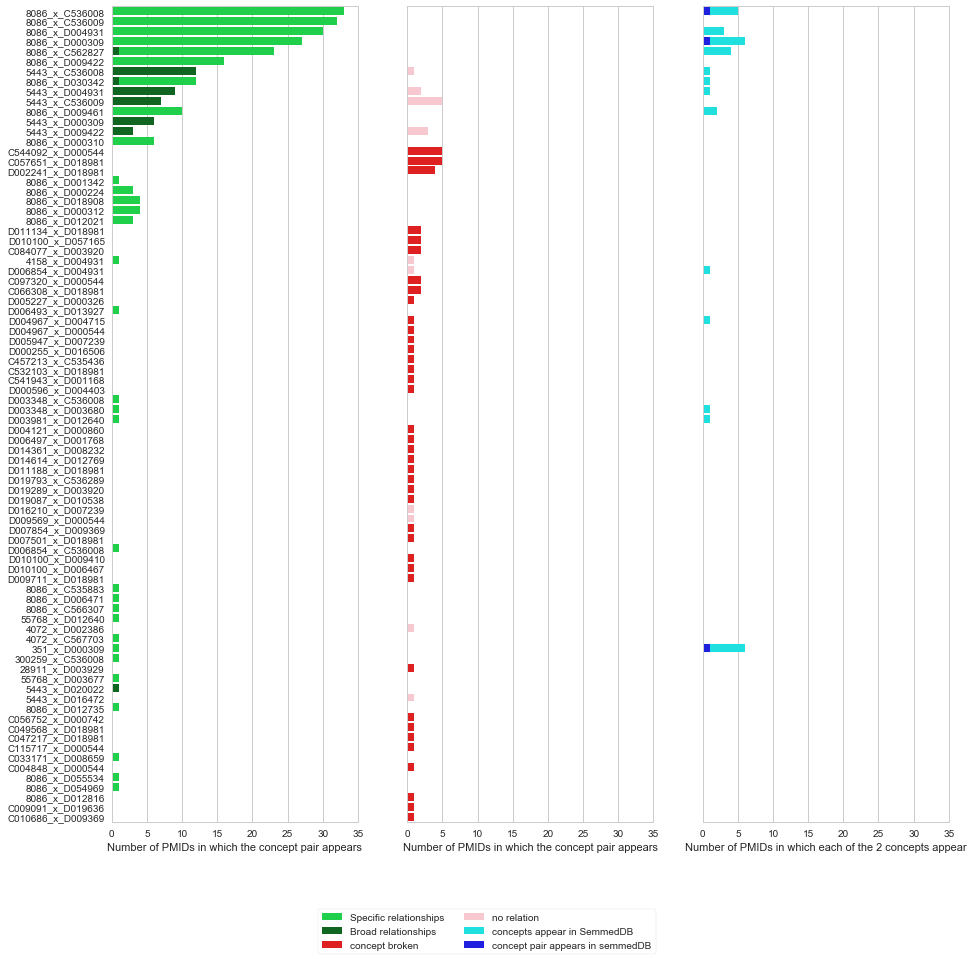

In [27]:
import seaborn as sns
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f = mplot.figure(figsize=(15,15))

# Plot the specific relationships involved
ax = mplot.subplot(1,3,1)
sns.set_color_codes("bright")
ax.yaxis.set_visible(True)
ax.xaxis.set_visible(True)
ax = sns.barplot(x="spec_rel", y="concept_pair", data=m2c_relation_cts,
            label="Specific relationships", color="g")

# Plot the broad relationships  involved
sns.set_color_codes("dark")
sns.barplot(x="broad_rel", y="concept_pair", data=m2c_relation_cts,
            label="Broad relationships", color="g")

ax.set(xlim=(0, 35), ylabel="",
       xlabel="Number of PMIDs in which the concept pair appears")

## Plot the broken and unrelated relationships
ax2 = mplot.subplot(1,3,2)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(True)
sns.set_color_codes("pastel")
ax2 = sns.barplot(x="cp_broken", y="concept_pair", data=m2c_relation_cts,
            label="concept broken", color="red")

sns.set_color_codes("bright")
sns.barplot(x="no_rel", y="concept_pair", data=m2c_relation_cts,
            label="no relation", color="pink")

ax2.set(xlim=(0, 35), ylabel="",
       xlabel="Number of PMIDs in which the concept pair appears")

# Plot the number of PMIDs in which both concepts were found in that pmid
sns.set_color_codes("muted")
ax3 = mplot.subplot(1,3,3)
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(True)
ax3 = sns.barplot(x="sem_pmid_cts", y="concept_pair", data=semmed_cp_appear_df,
            label="concepts appear in SemmedDB", color="cyan")

sns.barplot(x="sem_true_cp_ct", y="concept_pair", data=semmed_cp_appear_df,
            label="concept pair appears in semmedDB", color="blue")

ax3.set(xlim=(0, 35), ylabel="",
       xlabel="Number of PMIDs in which each of the 2 concepts appear")

# Add a legend and informative axis label
f.legend(ncol=2, loc="lower center", frameon=True)
#sns.despine(left=True, bottom=True)
mplot.show()